#Baixando dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
!pip -q install torchxrayvision

In [ ]:
import torchxrayvision as xrv

In [ ]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset

fatal: destination path 'covid-chestxray-dataset' already exists and is not an empty directory.


In [ ]:
data = xrv.datasets.COVID19_Dataset(imgpath="covid-chestxray-dataset/images/",csvpath="covid-chestxray-dataset/metadata.csv")

In [ ]:
data

{'Aspergillosis': {np.float32(0.0): 534, np.float32(1.0): 1},
 'Aspiration': {np.float32(0.0): 534, np.float32(1.0): 1},
 'Bacterial': {np.float32(0.0): 487, np.float32(1.0): 48},
 'COVID-19': {np.float32(0.0): 193, np.float32(1.0): 342},
 'Chlamydophila': {np.float32(0.0): 534, np.float32(1.0): 1},
 'Fungal': {np.float32(0.0): 512, np.float32(1.0): 23},
 'H1N1': {np.float32(0.0): 534, np.float32(1.0): 1},
 'Herpes ': {np.float32(0.0): 532, np.float32(1.0): 3},
 'Influenza': {np.float32(0.0): 531, np.float32(1.0): 4},
 'Klebsiella': {np.float32(0.0): 526, np.float32(1.0): 9},
 'Legionella': {np.float32(0.0): 526, np.float32(1.0): 9},
 'Lipoid': {np.float32(0.0): 527, np.float32(1.0): 8},
 'MERS-CoV': {np.float32(0.0): 527, np.float32(1.0): 8},
 'MRSA': {np.float32(0.0): 534, np.float32(1.0): 1},
 'Mycoplasma': {np.float32(0.0): 530, np.float32(1.0): 5},
 'No Finding': {np.float32(0.0): 520, np.float32(1.0): 15},
 'Nocardia': {np.float32(0.0): 531, np.float32(1.0): 4},
 'Pneumocystis': 

COVID19_Dataset num_samples=535 views=['PA', 'AP'] data_aug=None

In [ ]:
df = data.csv

In [ ]:
labels = []
imgs = []

for i in range(len(data)):
    pd.Series(dict(zip(data.pathologies,data[i]["lab"])))
    labels.append(pd.Series(dict(zip(data.pathologies,data[i]["lab"]))))
    imgs.append(data[i]["img"])

labels = pd.DataFrame(labels)
imgs = [i[0] for i in imgs]

In [ ]:
# prompt: encontrar casos onde todos os registros são 0

zeros = []
for index, row in labels.iterrows():
    if row.sum() == 0:
        zeros.append(index)
print(f"Indices where all records are zero: {zeros}")

Indices where all records are zero: []


In [ ]:
labels = labels['COVID-19']

In [ ]:
labels.value_counts()

COVID-19
1.0    342
0.0    193
Name: count, dtype: int64

# Tratamento dos dados

df = dados do paciente e do atendimento

labels = diagnóstico

img = imagens dos exames

In [ ]:
from PIL import Image
import numpy as np

def preprocess_images(img_list, target_size=(128, 128)):
    processed_images = []

    for img in img_list:
        # Garantir que está usando PIL.Image
        if isinstance(img, np.ndarray):
            img = Image.fromarray(img)
        else:
            img = img.convert('RGB')

        # Redimensionar
        img = img.resize(target_size, Image.LANCZOS)

        # Converter para numpy array e normalizar
        img_array = np.array(img) / 255.0  # Normalizar para 0-1
        processed_images.append(img_array)

    return np.array(processed_images)


In [ ]:
# Supondo que `img_array` seja sua lista de imagens PIL ou arrays numpy:
processed_imgs = preprocess_images(imgs)

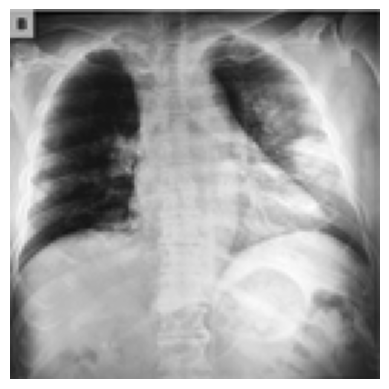

In [ ]:
plt.imshow(processed_imgs[1], cmap='gray')
plt.axis('off')
plt.show()

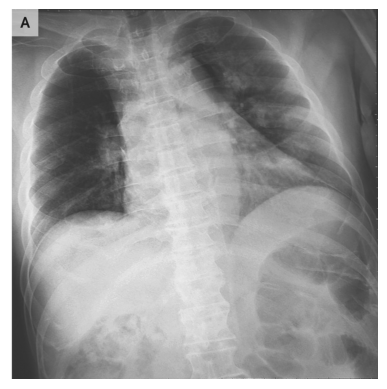

In [ ]:
plt.imshow(imgs[0], cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
import gc
del imgs
gc.collect()

3226

Tratando texto

In [ ]:
df['clinical_notes']

0      On January 22, 2020, a 65-year-old man with a ...
1      On January 22, 2020, a 65-year-old man with a ...
2      On January 22, 2020, a 65-year-old man with a ...
3      On January 22, 2020, a 65-year-old man with a ...
4       diffuse infiltrates in the bilateral lower lungs
                             ...                        
530    Decreased SpO2, elevated CRP and WBC, diffuse ...
531    Asthmatic. Shortness of breath and wheeze. Rou...
532    Asthmatic. Shortness of breath and wheeze. The...
533    fire-eater accidentally ingested a paraffin mi...
534    The patient, a heavy smoker, was referred to t...
Name: clinical_notes, Length: 535, dtype: object

In [ ]:
df[df['other_notes'].notna()]


index patientid  offset sex   age                         finding  \
39      48        20     NaN   M   NaN        Pneumonia/Viral/COVID-19   
40      50        21     7.0   F  50.0        Pneumonia/Viral/COVID-19   
41      51        22    10.0   M  70.0        Pneumonia/Viral/COVID-19   
42      54        23     NaN   F  70.0        Pneumonia/Viral/COVID-19   
43      57        24     NaN   M  75.0        Pneumonia/Viral/COVID-19   
..     ...       ...     ...  ..   ...                             ...   
528    941       477     7.0   F  60.0  Pneumonia/Bacterial/Legionella   
529    942       477     NaN   F  60.0  Pneumonia/Bacterial/Legionella   
530    943       478     NaN   F  75.0                      No Finding   
531    945       479     0.0   F  40.0                       Pneumonia   
532    946       479    70.0   F  40.0                       Pneumonia   

    RT_PCR_positive survival intubated intubation_present  ...  \
39          Unclear      NaN       NaN                NaN  ...   
40          Unclear      NaN       NaN                NaN  ...   
41                Y      NaN       NaN                NaN  ...   
42          Unclear      NaN       NaN                NaN  ...   
43          Unclear      NaN       NaN                NaN  ...   
..              ...      ...       ...                ...  ...   
528             NaN      NaN         Y                NaN  ...   
529             NaN      NaN         Y                  Y  ...   
530             NaN      NaN       NaN                NaN  ...   
531             NaN      NaN       NaN                NaN  ...   
532             NaN      NaN       NaN                NaN  ...   

                                location  folder  \
39                     Jonkoping, Sweden  images   
40                          Macao, China  images   
41                       Riccione, Italy  images   
42   Ospedale Santo Spirito. Rome, Italy  images   
43   Ospedale Santo Spirito. Rome, Italy  images   
..                                   ...     ...   
528                       United Kingdom  images   
529                       United Kingdom  images   
530                              Hungary  images   
531                       United Kingdom  images   
532                       United Kingdom  images   

                                         filename  doi  \
39                   covid-19-pneumonia-15-PA.jpg  NaN   
40                       covid-19-pneumonia-2.jpg  NaN   
41                    covid-19-pneumonia-7-PA.jpg  NaN   
42                   covid-19-pneumonia-14-PA.png  NaN   
43                      covid-19-pneumonia-12.jpg  NaN   
..                                            ...  ...   
528  bdc40f9ad2395d88c92479089f5d1b_jumbo-10.jpeg  NaN   
529  15d081345df9ca620ebe5e76023775_jumbo-10.jpeg  NaN   
530  02b973e10caa192fd4e6825ad4aeaf_jumbo-10.jpeg  NaN   
531   072ecaf8c60a81980abb57150a8016_jumbo-9.jpeg  NaN   
532   ff33c406392b968d483174c97eb857_jumbo-9.jpeg  NaN   

                                                   url      license  \
39   https://radiopaedia.org/cases/covid-19-pneumon...  CC BY-NC-SA   
40   https://radiopaedia.org/cases/covid-19-pneumon...  CC BY-NC-SA   
41   https://radiopaedia.org/cases/covid-19-pneumon...  CC BY-NC-SA   
42   https://radiopaedia.org/cases/covid-19-pneumon...  CC BY-NC-SA   
43   https://radiopaedia.org/cases/covid-19-pneumon...  CC BY-NC-SA   
..                                                 ...          ...   
528  https://radiopaedia.org/cases/legionella-pneum...  CC BY-NC-SA   
529  https://radiopaedia.org/cases/legionella-pneum...  CC BY-NC-SA   
530  https://radiopaedia.org/cases/right-middle-lob...  CC BY-NC-SA   
531  https://radiopaedia.org/cases/multifocal-round...  CC BY-NC-SA   
532  https://radiopaedia.org/cases/multifocal-round...  CC BY-NC-SA   

                                        clinical_notes  \
39   Elderly male, covid-19 positive. Fever and ele...   
40   Productive cough with a sor

# CNN Simples

## Definição da rede e treinamento com cross validation

In [ ]:
# Dataset customizado
class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Converter (256, 256) para (256, 256, 3)
        # image = np.stack([image] * 3, axis=-1) # REMOVA ESTA LINHA
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) # Adiciona um canal de dimensão (C, H, W)
        # A imagem será (1, 256, 256)

        # Converter para tensor e permutar para (C, H, W)

        label = torch.tensor(label, dtype=torch.float32)

        return image, label

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):

    def __init__(self):
        super().__init__()

        # input 256x256, output=64x256x256
        self.conv1 = nn.Conv2d(in_channels = 1,
                            out_channels = 64,
                            kernel_size = (3,3),
                            padding = 1)

        self.act1 = nn.ReLU()
        # self.drop1 = nn.Dropout(0.25)
        self.bn1 = nn.BatchNorm2d(64)

        # input 64x256x256, output=32x256x256
        self.conv2 = nn.Conv2d(in_channels = 64,
                            out_channels = 32,
                            kernel_size = (3,3),
                            padding = 1)

        self.act2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(32)

        # output=32x64x64
        self.pool1 = nn.MaxPool2d(kernel_size = (4,4),
                              stride = 4)

        # vetor de 131072, 32768 se img = 128x128
        self.flat = nn.Flatten()

        self.lin1 = nn.Linear(in_features = 32768,
                          out_features = 16384)

        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.25)
        #self.drop3 = nn.Dropout(0.5)

        self.lin2 = nn.Linear(in_features = 16384,
                                out_features = 512)

        self.drop4 = nn.Dropout(0.25)
        self.act4 = nn.ReLU()

        self.lin3 = nn.Linear(in_features = 512,
                                out_features = 1)

        #self.act5 = nn.Softmax()

    def forward(self, x):
        # primeira camada
        x = self.conv1(x)
        x = self.act1(x)
        # x = self.drop1(x)
        x = self.bn1(x)

        # segunda camada
        x = self.conv2(x)
        x = self.act2(x)
        # x = self.drop2(x)
        x = self.bn2(x)
        x = self.pool1(x)

        # flatten, projeção e classificação
        x = self.flat(x)
        x = self.lin1(x)
        x = self.drop3(x)
        x = self.act3(x)

        x = self.lin2(x)
        x = self.drop4(x)
        x = self.act4(x)

        x = self.lin3(x)
        #x = self.act5(x)

        return x

# Inicializar modelo
num_classes = 2  # número de labels



In [ ]:
n_splits = 5

# --- 3. Inicializar o StratifiedKFold ---
# Usamos a coluna binária de COVID-19 para estratificar, garantindo que o COVID-19 esteja em cada fold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# --- 4. Loop de Validação Cruzada ---
all_fold_covid_accuracy = []
all_fold_covid_precision = []
all_fold_covid_recall = []
all_fold_covid_f1 = []

# Loop sobre cada fold
for fold, (train_index, val_index) in enumerate(skf.split(processed_imgs, labels)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")

    # --- 4.1. Criar Datasets e DataLoaders para o Fold Atual ---
    X_train_fold, X_val_fold = processed_imgs[train_index], processed_imgs[val_index]
    y_train_fold, y_val_fold = labels.iloc[train_index].reset_index(drop=True), labels.iloc[val_index].reset_index(drop=True)

    train_dataset = ImageDataset(X_train_fold, y_train_fold)
    val_dataset = ImageDataset(X_val_fold, y_val_fold)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # --- 4.2. Reinicializar Modelo e Otimizador para cada Fold ---
    # É importante começar com um modelo "fresco" em cada fold para uma avaliação imparcial
    model = SimpleCNN()
    model.to(device)

    # num_pos_fold = np.sum(y_train_fold == 1)
    # num_neg_fold = np.sum(y_train_fold == 0)

    # # Avoid division by zero if there are no positive samples in a fold (unlikely with StratifiedKFold)
    # if num_pos_fold > 0:
    #     pos_weight_scalar_fold = torch.tensor(num_neg_fold / num_pos_fold, dtype=torch.float32).to(device)
    # else:
    #     pos_weight_scalar_fold = torch.tensor(1.0, dtype=torch.float32).to(device) # Or a large value if appropriate

    criterion = nn.BCEWithLogitsLoss() # Use a loss com os pesos
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # --- 4.3. Loop de Treinamento e Validação para o Fold Atual ---
    # Este é o loop que você já tem, mas adaptado para um único fold
    n_epochs_per_fold = 10 # Você pode querer menos épocas por fold ou usar Early Stopping
    for epoch in range(n_epochs_per_fold):
        # ... (Seu código de Treinamento - model.train(), optimizer.zero_grad(), etc.)
        model.train()
        running_loss = 0.0
        for images, labels_batch in train_loader:
            images = images.to(device)
            labels_batch = labels_batch.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss_train = running_loss / len(train_loader.dataset)
        print(f"  Fold {fold+1}, Epoch {epoch+1} Treinamento - Loss: {epoch_loss_train:.4f}")

        # ... (Seu código de Validação - model.eval(), torch.no_grad(), coleta de predictions/true_labels)
        model.eval()
        val_running_loss = 0.0
        predictions_fold = []
        true_labels_fold = []
        with torch.no_grad():
            for images, labels_batch in val_loader:
                images = images.to(device)
                labels_batch = labels_batch.to(device)
                outputs = model(images)
                loss = criterion(outputs.squeeze(), labels_batch)
                val_running_loss += loss.item() * images.size(0)
                predictions_fold.append(outputs.cpu())
                true_labels_fold.append(labels_batch.cpu())

        predictions_fold = torch.cat(predictions_fold)
        true_labels_fold = torch.cat(true_labels_fold)
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        print(f"  Fold {fold+1}, Epoch {epoch+1} Validação - Loss: {val_epoch_loss:.4f}")

    # --- 4.4. Calcular Métricas para COVID-19 para o Fold Atual ---
    prob_fold = torch.sigmoid(predictions_fold)
    covid_true_fold = true_labels_fold.numpy()
    threshold = 0.5 # Mantenha o threshold fixo para comparação entre folds
    covid_pred_fold = (prob_fold > threshold).float().numpy()

    covid_accuracy_fold = accuracy_score(covid_true_fold, covid_pred_fold)
    covid_precision_fold = precision_score(covid_true_fold, covid_pred_fold, zero_division=0)
    covid_recall_fold = recall_score(covid_true_fold, covid_pred_fold, zero_division=0)
    covid_f1_fold = f1_score(covid_true_fold, covid_pred_fold, zero_division=0)

    print(f"  Fold {fold+1} COVID-19 - Acurácia: {covid_accuracy_fold:.4f}, Precisão: {covid_precision_fold:.4f}, Recall: {covid_recall_fold:.4f}, F1: {covid_f1_fold:.4f}")

    # Armazenar métricas para média final
    all_fold_covid_accuracy.append(covid_accuracy_fold)
    all_fold_covid_precision.append(covid_precision_fold)
    all_fold_covid_recall.append(covid_recall_fold)
    all_fold_covid_f1.append(covid_f1_fold)

# --- 5. Resultados Finais da Validação Cruzada ---
print("\n--- Resultados Finais da Validação Cruzada para COVID-19 ---")
print(f"Acurácia Média: {np.mean(all_fold_covid_accuracy):.4f} +/- {np.std(all_fold_covid_accuracy):.4f}")
print(f"Precisão Média: {np.mean(all_fold_covid_precision):.4f} +/- {np.std(all_fold_covid_precision):.4f}")
print(f"Recall Médio: {np.mean(all_fold_covid_recall):.4f} +/- {np.std(all_fold_covid_recall):.4f}")
print(f"F1-score Médio: {np.mean(all_fold_covid_f1):.4f} +/- {np.std(all_fold_covid_f1):.4f}")


--- Fold 1/5 ---
  Fold 1, Epoch 1 Treinamento - Loss: 10.8866
  Fold 1, Epoch 1 Validação - Loss: 0.7071
  Fold 1, Epoch 2 Treinamento - Loss: 0.7275
  Fold 1, Epoch 2 Validação - Loss: 0.5949
  Fold 1, Epoch 3 Treinamento - Loss: 0.6457
  Fold 1, Epoch 3 Validação - Loss: 0.5907
  Fold 1, Epoch 4 Treinamento - Loss: 0.6529
  Fold 1, Epoch 4 Validação - Loss: 0.6471
  Fold 1, Epoch 5 Treinamento - Loss: 0.5982
  Fold 1, Epoch 5 Validação - Loss: 0.6074
  Fold 1, Epoch 6 Treinamento - Loss: 0.6012
  Fold 1, Epoch 6 Validação - Loss: 0.5881
  Fold 1, Epoch 7 Treinamento - Loss: 0.5794
  Fold 1, Epoch 7 Validação - Loss: 0.6532
  Fold 1, Epoch 8 Treinamento - Loss: 0.5541
  Fold 1, Epoch 8 Validação - Loss: 0.5691
  Fold 1, Epoch 9 Treinamento - Loss: 0.5761
  Fold 1, Epoch 9 Validação - Loss: 0.6492
  Fold 1, Epoch 10 Treinamento - Loss: 0.5851
  Fold 1, Epoch 10 Validação - Loss: 0.6138
  Fold 1 COVID-19 - Acurácia: 0.6449, Precisão: 0.7385, Recall: 0.6957, F1: 0.7164

--- Fold 2/5 --

## Testando e visualizando o modelo

In [ ]:
# Divisão em treino e teste (80/20 por padrão)
X_train, X_test, y_train, y_test = train_test_split(
    processed_imgs,
    labels,  # converte para numpy
    test_size=0.2,
    random_state=42,
)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

batch_size = 16

# Criar datasets
train_dataset = ImageDataset(X_train, y_train)
test_dataset = ImageDataset(X_test, y_test)

# Criar dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [ ]:
model = SimpleCNN()
model.to(device)

criterion = nn.BCEWithLogitsLoss() # Use a loss com os pesos
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Loop de treinamento e validação para plotar as curvas de loss
n_epochs = 20
patience = 3

hist_tr_loss = []
hist_val_loss = []
hist_val_acc = []

early_stopping = EarlyStopping(patience=patience)

for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}")

    # ---------- Treinamento ----------
    model.train()  # Modo treino
    epoch_train_loss = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float()  # Garantir float para BCEWithLogitsLoss

        y_hat = model(inputs).squeeze()  # Saída [batch_size]

        loss = criterion(y_hat, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()  # loss.item() = escalar (float)

    avg_train_loss = epoch_train_loss / len(train_loader)
    hist_tr_loss.append(avg_train_loss)
    print(f"Train loss: {avg_train_loss:.4f}")

    # ---------- Validação ----------
    model.eval()  # Modo avaliação
    epoch_val_loss = 0
    total_correct = 0
    total_elements = 0

    with torch.no_grad():
        for val_inputs, val_labels in test_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device).float()

            y_hat = model(val_inputs).squeeze()
            loss = criterion(y_hat, val_labels)

            epoch_val_loss += loss.item()

            # Calcular acurácia
            preds = (torch.sigmoid(y_hat) > 0.5).float()
            total_correct += (preds == val_labels).sum().item()
            total_elements += val_labels.numel()

    avg_val_loss = epoch_val_loss / len(test_loader)
    val_acc = total_correct / total_elements

    hist_val_loss.append(avg_val_loss)
    hist_val_acc.append(val_acc)

    print(f"Val loss: {avg_val_loss:.4f} - Val acc: {val_acc:.4f}")

    # early stopping
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

# plotly para visualizar
fig = go.Figure()
fig.add_trace(go.Scatter(y=hist_tr_loss, mode='lines+markers', name='Train Loss'))
fig.add_trace(go.Scatter(y=hist_val_loss, mode='lines+markers', name='Val Loss'))
fig.update_layout(title='Train vs Val Loss', xaxis_title='Epochs', yaxis_title='Loss', template='plotly_white')
fig.show()

Epoch 1/20
Train loss: 12.6417
Val loss: 1.2897 - Val acc: 0.5888
Epoch 2/20
Train loss: 0.6949
Val loss: 0.7882 - Val acc: 0.5888
Epoch 3/20
Train loss: 0.6106
Val loss: 1.3765 - Val acc: 0.5981
Epoch 4/20
Train loss: 0.6841
Val loss: 0.7880 - Val acc: 0.5981
Epoch 5/20
Train loss: 0.6258
Val loss: 0.6585 - Val acc: 0.6262
Epoch 6/20
Train loss: 0.6452
Val loss: 0.6934 - Val acc: 0.6355
Epoch 7/20
Train loss: 0.5877
Val loss: 0.6985 - Val acc: 0.6636
Epoch 8/20
Train loss: 0.5448
Val loss: 0.6089 - Val acc: 0.6449
Epoch 9/20
Train loss: 0.5400
Val loss: 0.6880 - Val acc: 0.6075
Epoch 10/20
Train loss: 0.5568
Val loss: 0.6405 - Val acc: 0.6262
Epoch 11/20
Train loss: 0.5269
Val loss: 0.6676 - Val acc: 0.6355
Early stopping triggered!


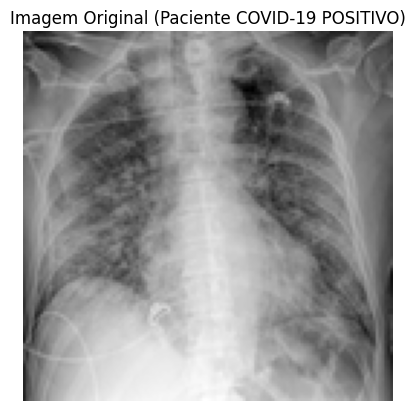

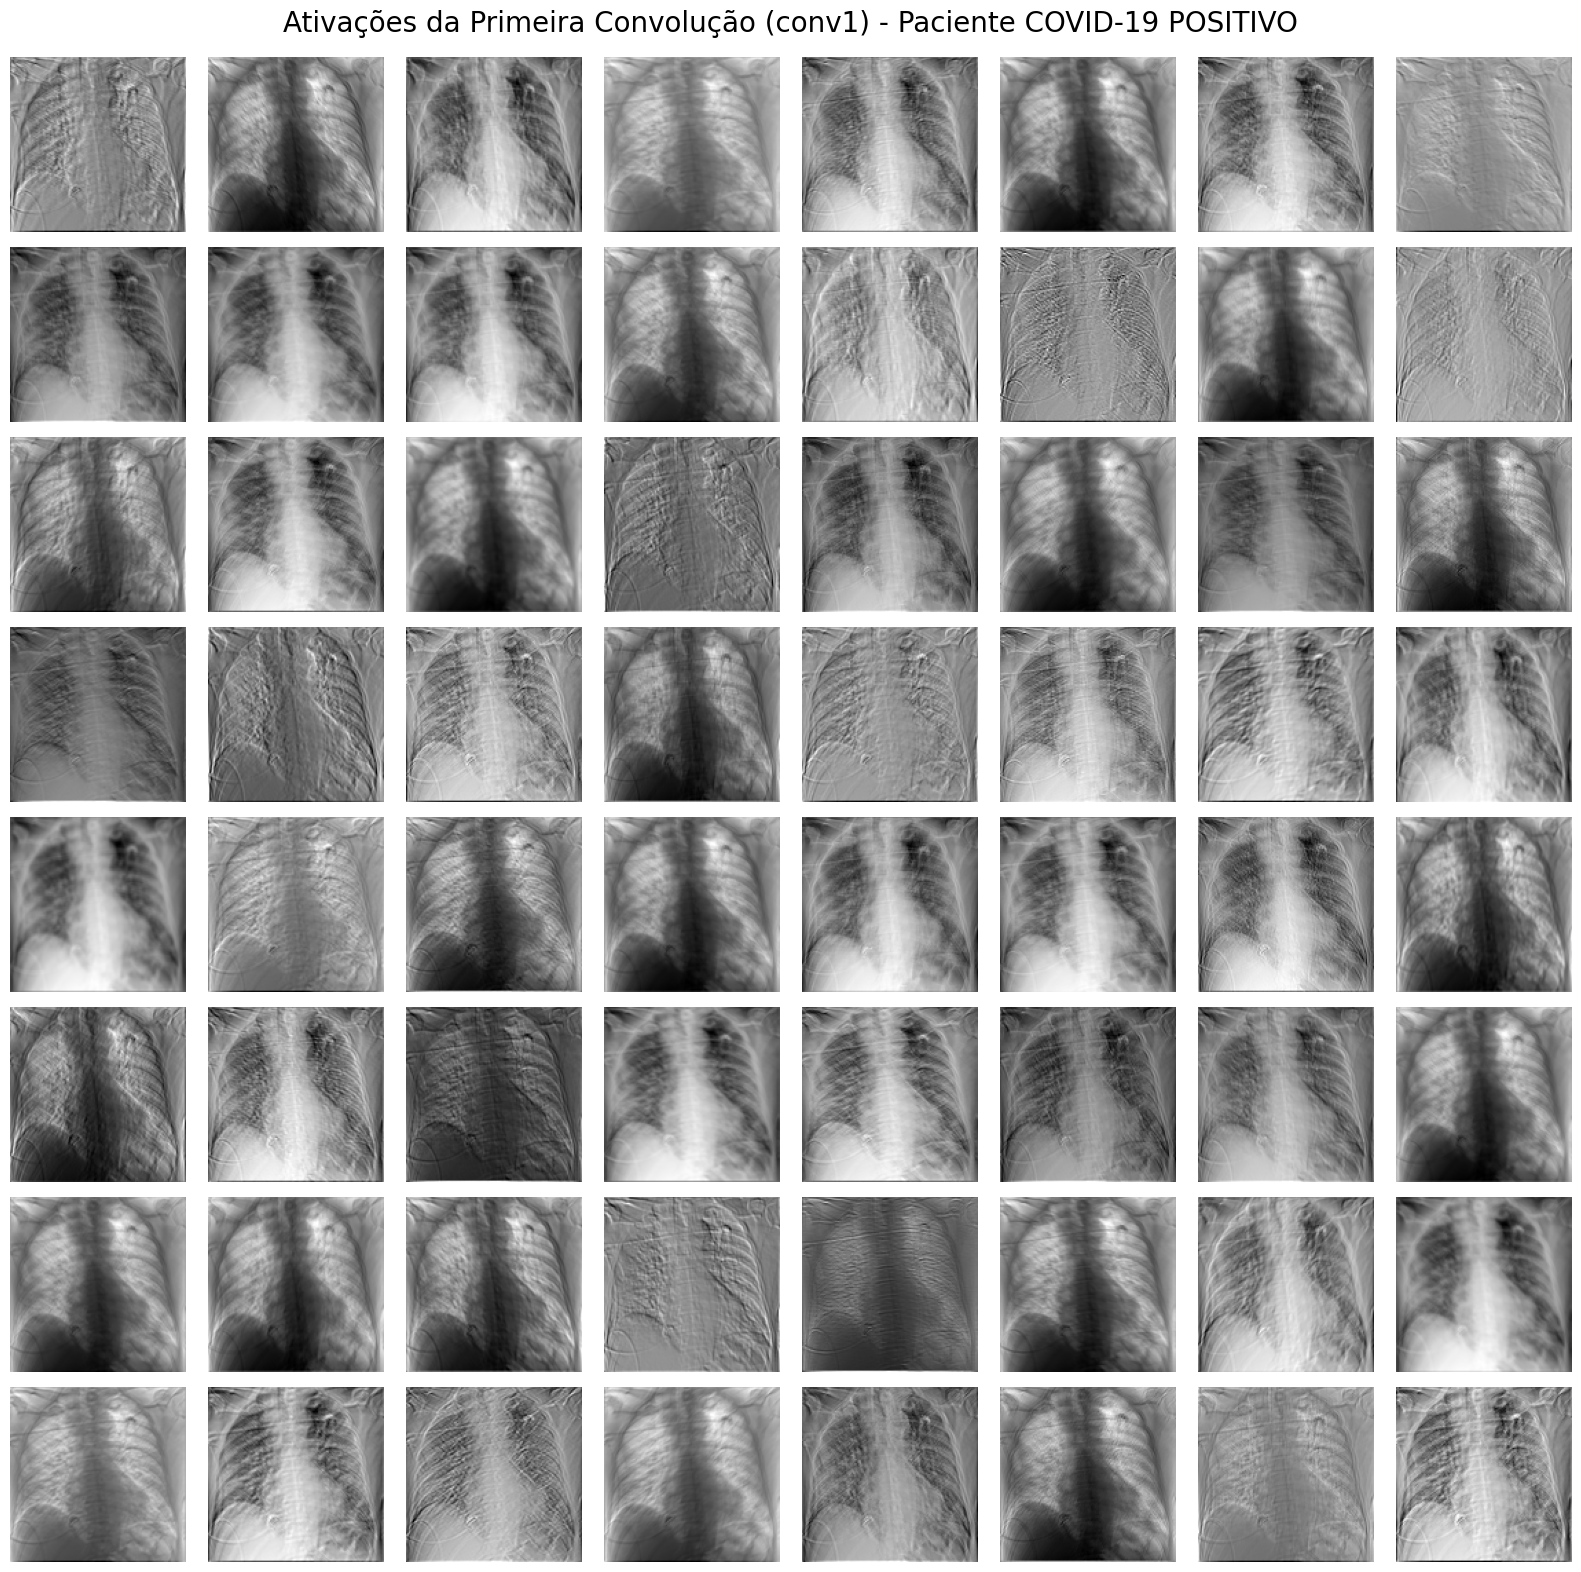

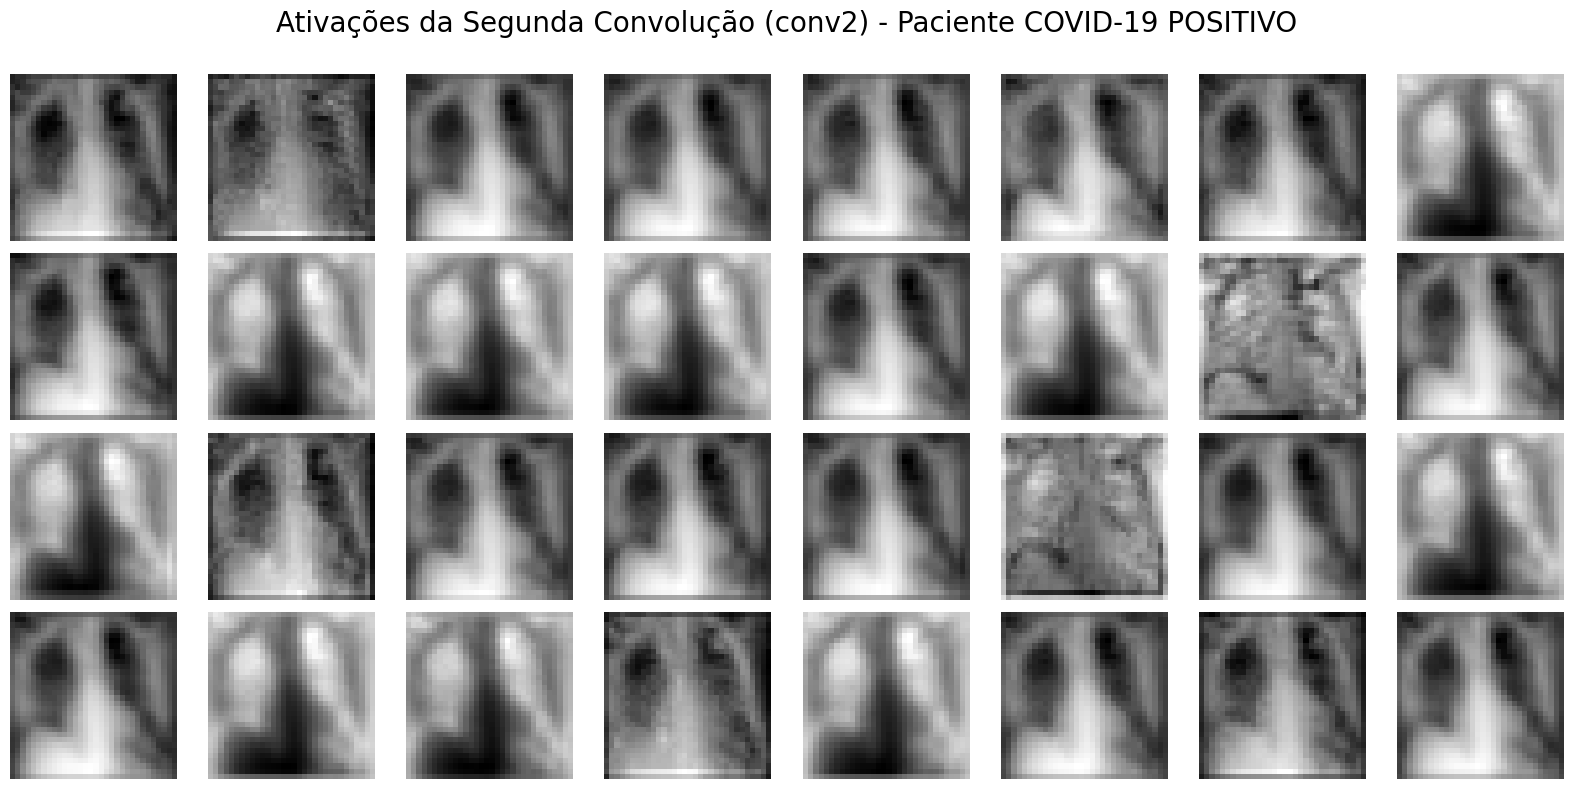

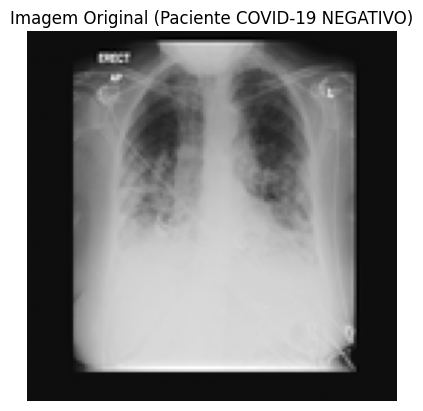

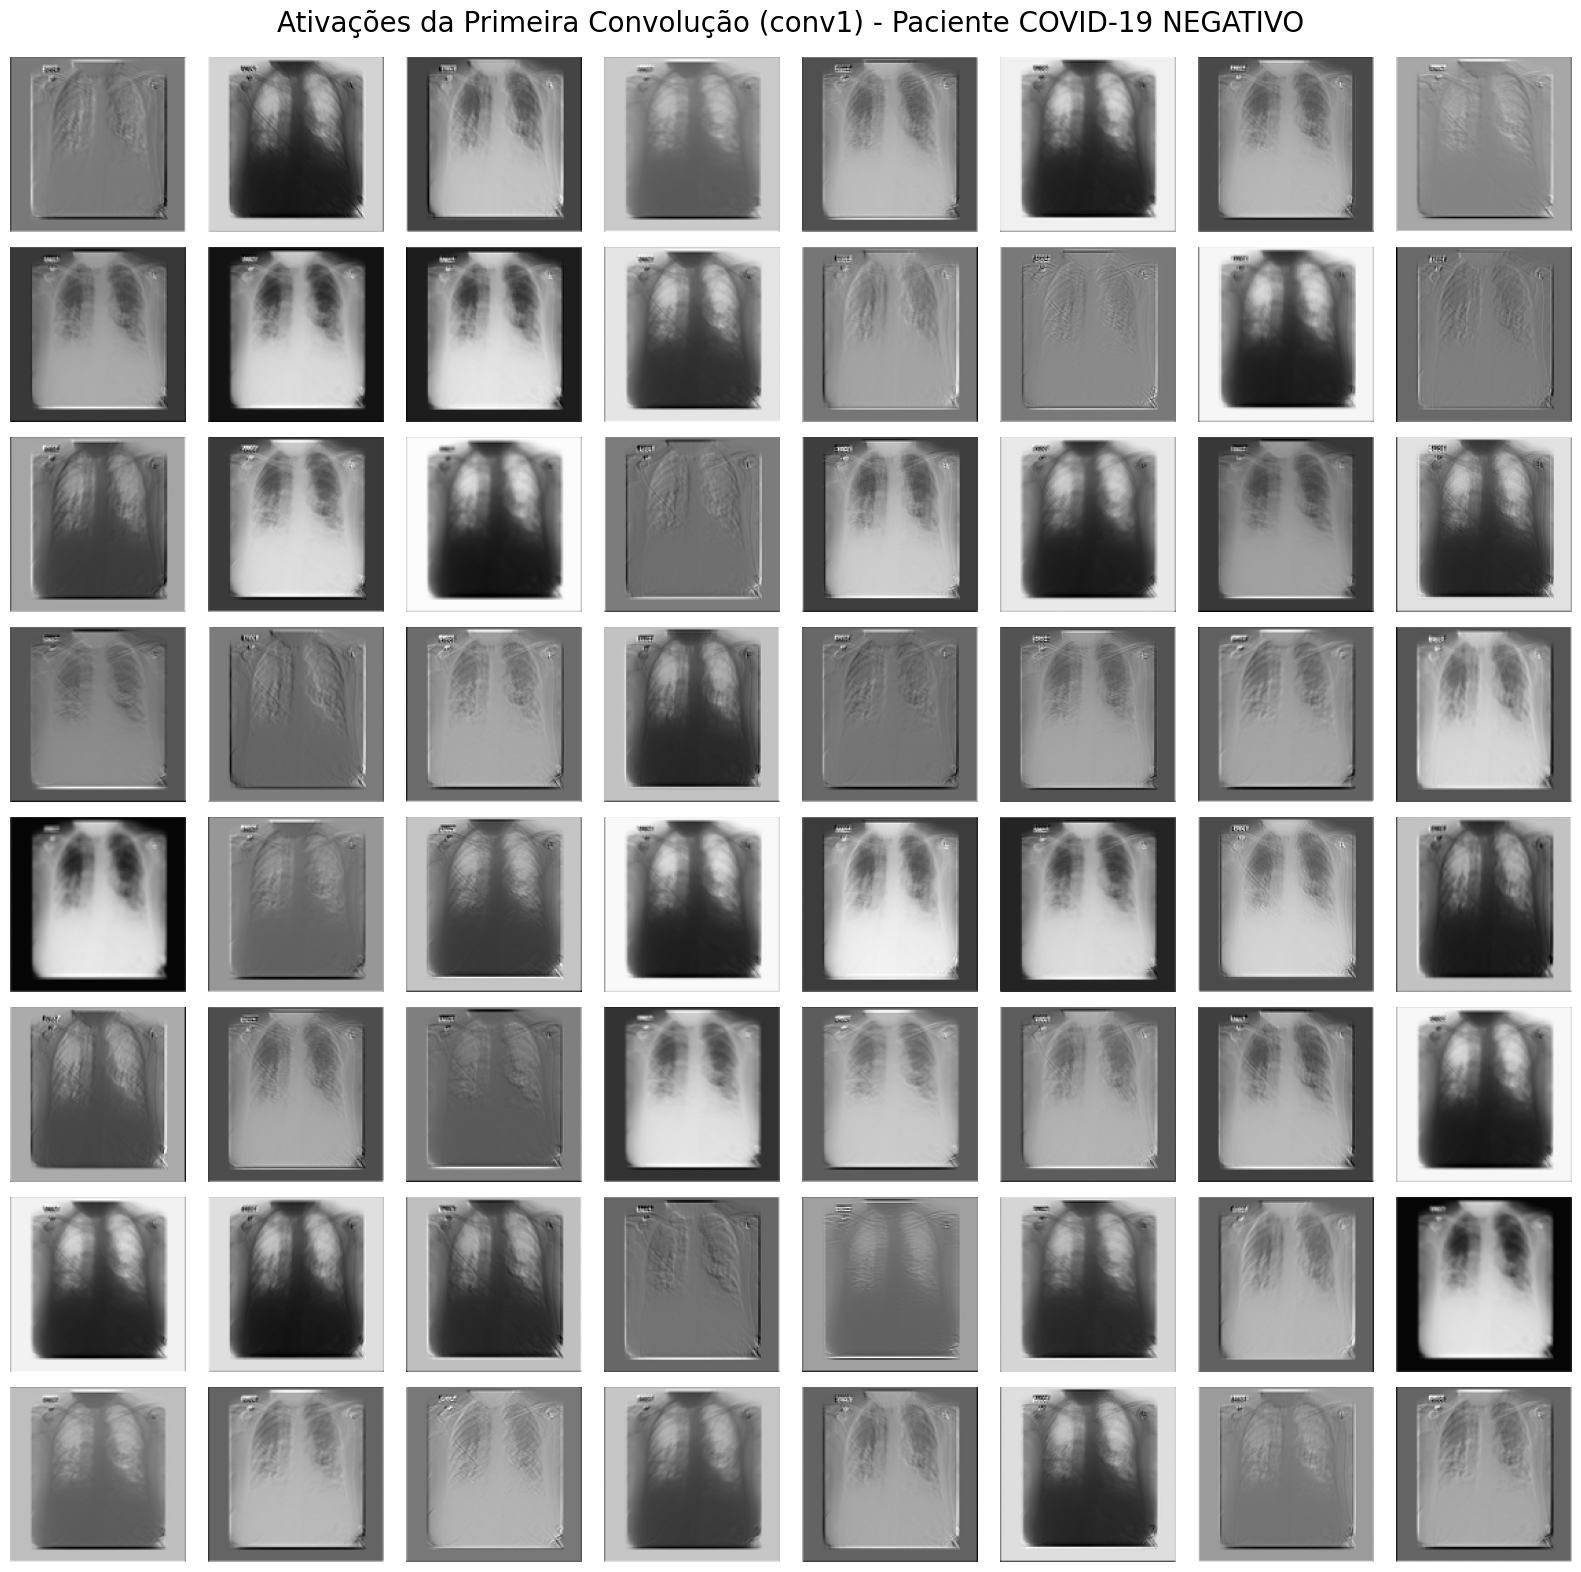

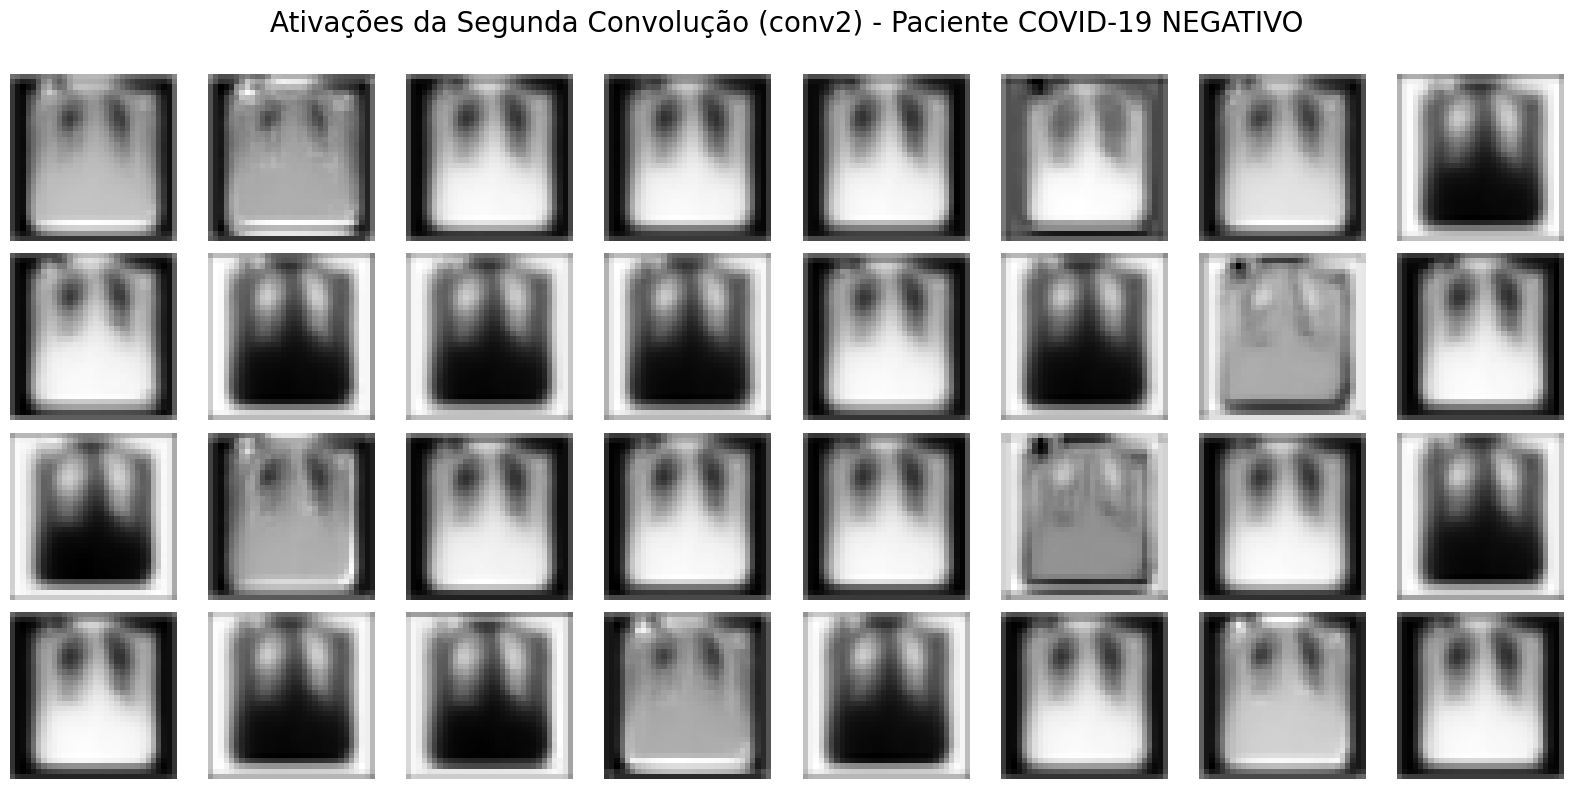

In [ ]:
import matplotlib.pyplot as plt

model.eval()

# Função para plotar as ativações
def plot_activations(sample_img, label_text):
    with torch.no_grad():
        # Ativação após conv1
        activation1_relu = model.conv1(sample_img)
        #activation1_relu = model.act1(activation1)

        # Ativação após conv2
        x = model.pool1(activation1_relu)
        activation2_relu = model.conv2(x)
        #activation2_relu = model.act2(activation2)

    # Plotar a imagem original
    img_np = sample_img.squeeze().cpu().numpy()
    plt.imshow(img_np, cmap='gray')
    plt.title(f"Imagem Original ({label_text})")
    plt.axis('off')
    plt.show()

    # Plotar as ativações da primeira convolução
    fig, axes = plt.subplots(8, 8, figsize=(16, 16))
    for i, ax in enumerate(axes.flat):
        ax.imshow(activation1_relu[0, i].cpu().numpy(), cmap='gray')
        ax.axis('off')
    plt.suptitle(f"Ativações da Primeira Convolução (conv1) - {label_text}", fontsize=20)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

    # Plotar as ativações da segunda convolução
    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(activation2_relu[0, i].cpu().numpy(), cmap='gray')
        ax.axis('off')
    plt.suptitle(f"Ativações da Segunda Convolução (conv2) - {label_text}", fontsize=20)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()

# Função para buscar uma amostra com o label desejado (0 ou 1)
def get_sample_with_label(loader, target_label):
    for img, label in loader:
        # Como são multi-label binários, label já está no shape (batch_size, 1)
        if label[0].item() == target_label:
            return img[0].unsqueeze(0).to(device)
    return None

# Exibir exemplo POSITIVO (label=1)
sample_img_pos = get_sample_with_label(test_loader, target_label=1)
if sample_img_pos is not None:
    plot_activations(sample_img_pos, "Paciente COVID-19 POSITIVO")
else:
    print("Nenhuma amostra positiva encontrada no test_loader.")

# Exibir exemplo NEGATIVO (label=0)
sample_img_neg = get_sample_with_label(test_loader, target_label=0)
if sample_img_neg is not None:
    plot_activations(sample_img_neg, "Paciente COVID-19 NEGATIVO")
else:
    print("Nenhuma amostra negativa encontrada no test_loader.")


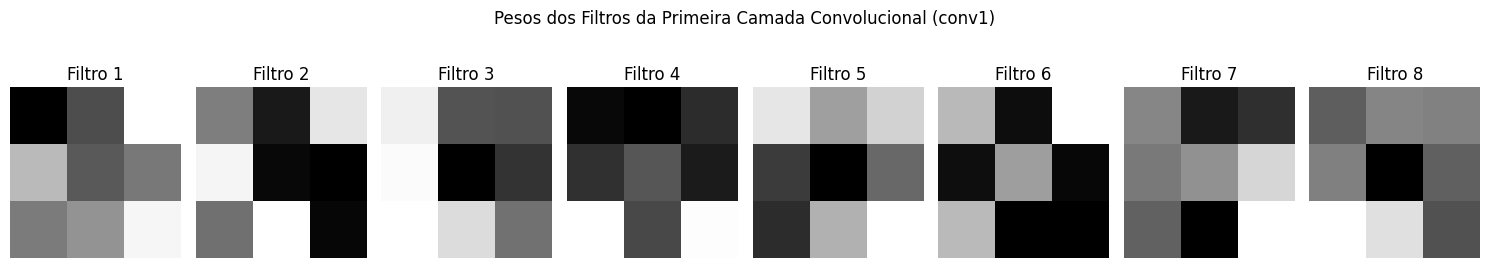

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# model = SimpleCNN()
# model.load_state_dict(torch.load('seu_modelo.pth'))
model.eval()

# Pegar os pesos da primeira camada convolucional
# conv1.weight tem shape (out_channels, in_channels, kernel_height, kernel_width)
filters_conv1 = model.conv1.weight.data.cpu().numpy()

# Visualizar alguns filtros (ex: os 8 primeiros)
num_filters_to_show = 8
plt.figure(figsize=(15, 3))
for i in range(num_filters_to_show):
    plt.subplot(1, num_filters_to_show, i + 1)
    # A imagem de entrada é grayscale (1 canal), então o filtro também terá 1 canal
    # Squeeze para remover a dimensão do canal de entrada (se houver)
    filter_img = filters_conv1[i, 0, :, :]
    plt.imshow(filter_img, cmap='gray')
    plt.title(f'Filtro {i+1}')
    plt.axis('off')
plt.suptitle('Pesos dos Filtros da Primeira Camada Convolucional (conv1)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta layout para o suptitle
plt.show()

# ResNets

## Definições gerais

In [ ]:
from PIL import Image
import numpy as np

def preprocess_images(img_list, target_size=(224, 224)):
    processed_images = []

    # Média e desvio padrão do ImageNet
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])

    for img in img_list:
        # Garantir que a imagem está em RGB com 3 canais
        if isinstance(img, np.ndarray):
            if img.ndim == 2:  # imagem grayscale (H, W)
                img = np.stack([img]*3, axis=-1)  # (H, W, 3)
            img = Image.fromarray(img.astype(np.uint8))
        else:
            img = img.convert('RGB')

        # Redimensionar
        img = img.resize(target_size, Image.LANCZOS)

        # Converter para numpy e normalizar para 0-1
        img_array = np.array(img).astype(np.float32) / 255.0  # (H, W, 3)

        # Normalizar por canal
        img_array = (img_array - imagenet_mean) / imagenet_std  # broadcasting por canal

        processed_images.append(img_array)

    return np.array(processed_images)  # (N, 224, 224, 3)

processed_imgs = preprocess_images(imgs)

import gc
del imgs
gc.collect()

0

In [ ]:
from torch.utils.data import Dataset
import torch
import numpy as np
from torchvision import transforms

class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        images: np.ndarray com shape (N, H, W) ou (N, H, W, 3)
        labels: lista, np.ndarray ou pd.Series
        transform: torchvision.transforms (incluindo ToTensor + Normalize)
        """
        self.images = images
        self.labels = np.array(labels)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        # Garante 3 canais (RGB)
        if image.ndim == 2:
            image = np.stack([image] * 3, axis=-1)

        image = image.astype(np.uint8)  # necessário para ToPILImage()

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return image, label

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

In [ ]:
# --- Transforms (ImageNet normalization) ---
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.ToPILImage(),       # de np.uint8 → PIL.Image
    transforms.ToTensor(),         # de PIL → tensor [0, 1], com shape (C, H, W)
    transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [ ]:
# --- Transforms (Com Data Augmentation) ---
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


## ResNet18

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]


Epoch 1 - Train Loss: 0.5240, Val Loss: 1.7329
Epoch 2 - Train Loss: 0.1744, Val Loss: 1.2510
Epoch 3 - Train Loss: 0.1332, Val Loss: 0.2366
Epoch 4 - Train Loss: 0.0691, Val Loss: 0.2588
Epoch 5 - Train Loss: 0.0347, Val Loss: 0.4943
Epoch 6 - Train Loss: 0.0437, Val Loss: 0.2727
Epoch 7 - Train Loss: 0.0395, Val Loss: 0.4602
Epoch 8 - Train Loss: 0.0430, Val Loss: 0.3550
Epoch 9 - Train Loss: 0.0437, Val Loss: 0.5693
Epoch 10 - Train Loss: 0.0289, Val Loss: 0.8558
Epoch 11 - Train Loss: 0.0091, Val Loss: 0.9435
Epoch 12 - Train Loss: 0.0250, Val Loss: 0.9229
Epoch 13 - Train Loss: 0.0164, Val Loss: 0.5020
⏹️ Early stopping no epoch 13

📊 Avaliação Final (Holdout)
Acurácia: 0.6075
Precisão: 0.7241
Recall: 0.6176
F1-score: 0.6667


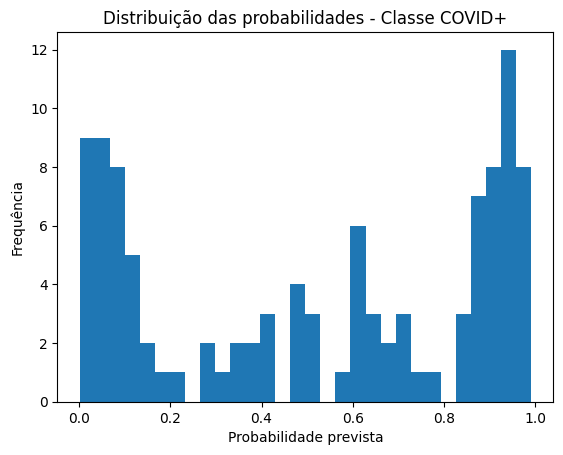

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Holdout split ---
X_train, X_val, y_train, y_val = train_test_split(
    processed_imgs, labels, test_size=0.2, stratify=labels, random_state=42)

# --- Datasets e loaders ---
# Ensure labels are integers when creating datasets
train_dataset = ImageDataset(X_train, y_train.reset_index(drop=True).astype(int), transform=train_transform)
val_dataset = ImageDataset(X_val, y_val.reset_index(drop=True).astype(int), transform=val_transform)

# --- WeightedRandomSampler (opcional, mas recomendado) ---
# Ensure labels are integers before calculating class counts
labels_np = np.array(y_train).astype(int)
class_sample_count = np.array([len(np.where(labels_np == t)[0]) for t in np.unique(labels_np)])
weight = 1. / class_sample_count
# Access weight using integer indices
samples_weight = np.array([weight[t] for t in labels_np])
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# --- Modelo: ResNet18 ---
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes
model = model.to(device)

# --- Treinamento ---
criterion = FocalLoss(alpha=1.0, gamma=2.0)
#criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 50
patience = 10
best_val_loss = float('inf')
best_model_weights = None
epochs_no_improve = 0

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for images, labels_batch in train_loader:
        images, labels_batch = images.to(device), labels_batch.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    # --- Validação ---
    model.eval()
    val_loss_total = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels_batch in val_loader:
            images, labels_batch = images.to(device), labels_batch.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels_batch)
            val_loss_total += loss.item() * images.size(0)
            all_preds.append(outputs.cpu())
            all_labels.append(labels_batch.cpu())

    val_loss = val_loss_total / len(val_loader.dataset)
    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        best_model_weights = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"⏹️ Early stopping no epoch {epoch+1}")
            break

# --- Avaliação final ---
if best_model_weights:
    model.load_state_dict(best_model_weights)

model.eval()
logits_list = []
labels_list = []

with torch.no_grad():
    for images, labels_batch in val_loader:
        images = images.to(device)
        outputs = model(images)
        logits_list.append(outputs.cpu())
        labels_list.append(labels_batch)

logits = torch.cat(logits_list)
true_labels = torch.cat(labels_list)
probs = torch.softmax(logits, dim=1)[:, 1].numpy()
preds = (probs > 0.5).astype(np.float32)
true = true_labels.numpy()

# --- Métricas ---
acc = accuracy_score(true, preds)
prec = precision_score(true, preds, zero_division=0)
rec = recall_score(true, preds, zero_division=0)
f1 = f1_score(true, preds, zero_division=0)

print("\n📊 Avaliação Final (Holdout)")
print(f"Acurácia: {acc:.4f}")
print(f"Precisão: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

# --- Diagnóstico: distribuição dos scores de probabilidade ---
plt.hist(probs, bins=30)
plt.title("Distribuição das probabilidades - Classe COVID+")
plt.xlabel("Probabilidade prevista")
plt.ylabel("Frequência")
plt.show()

## ResNet34

Epoch 1 - Train Loss: 0.4664, Val Loss: 10.2557, F1: 0.7771
Epoch 2 - Train Loss: 0.1733, Val Loss: 0.7700, F1: 0.4255
Epoch 3 - Train Loss: 0.1543, Val Loss: 0.5237, F1: 0.4468
Epoch 4 - Train Loss: 0.1557, Val Loss: 0.2626, F1: 0.6387
Epoch 5 - Train Loss: 0.1500, Val Loss: 0.1721, F1: 0.7703
Epoch 6 - Train Loss: 0.1352, Val Loss: 0.1931, F1: 0.7949
Epoch 7 - Train Loss: 0.1459, Val Loss: 0.1726, F1: 0.7083
Epoch 8 - Train Loss: 0.1258, Val Loss: 0.2144, F1: 0.6457
Epoch 9 - Train Loss: 0.1033, Val Loss: 0.2616, F1: 0.7333
Epoch 10 - Train Loss: 0.1023, Val Loss: 0.6800, F1: 0.2963
Epoch 11 - Train Loss: 0.1169, Val Loss: 0.2363, F1: 0.7568
Epoch 12 - Train Loss: 0.1097, Val Loss: 0.4677, F1: 0.3913
Epoch 13 - Train Loss: 0.0874, Val Loss: 0.3952, F1: 0.7284
Epoch 14 - Train Loss: 0.0794, Val Loss: 0.2204, F1: 0.7682
Epoch 15 - Train Loss: 0.0797, Val Loss: 0.4648, F1: 0.7712
⏹️ Early stopping no epoch 15

📊 Avaliação Final (Holdout - ResNet34 + Scheduler)
Acurácia: 0.6729
Precisão:

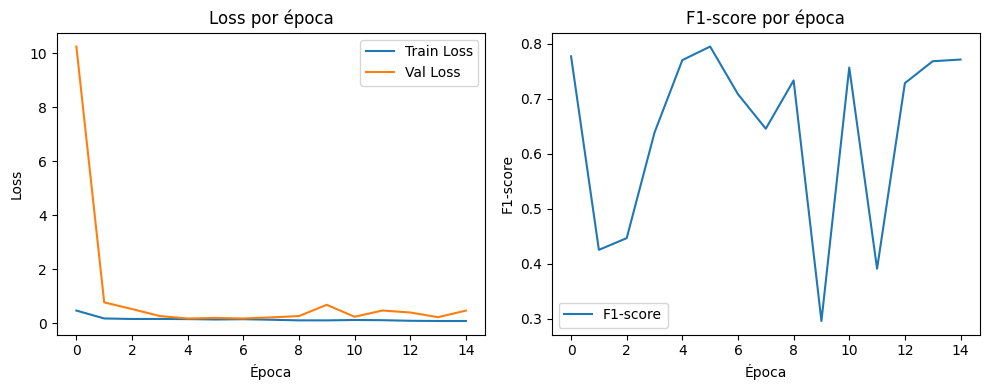

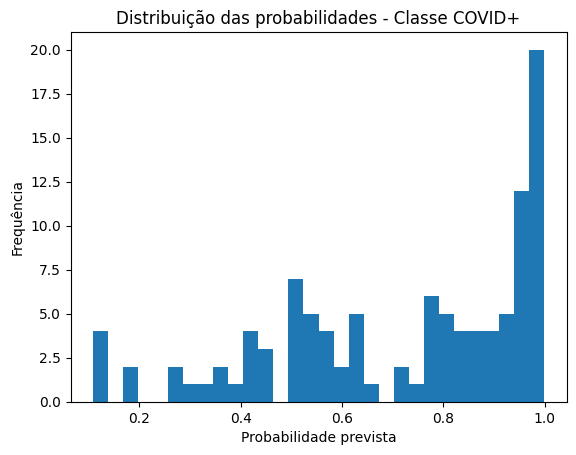


🧪 Erros mais confiantes:


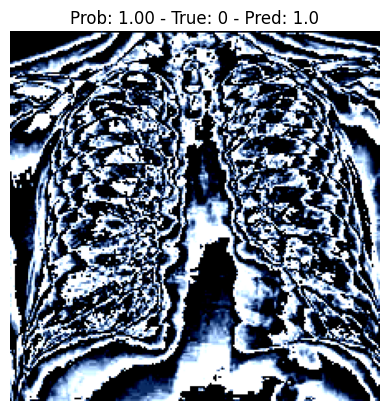

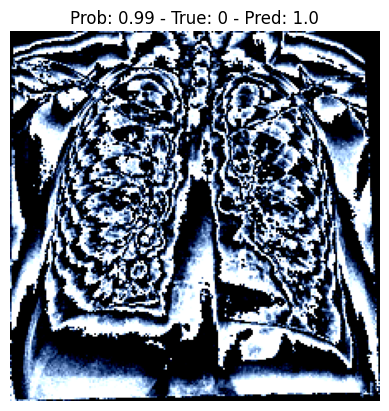

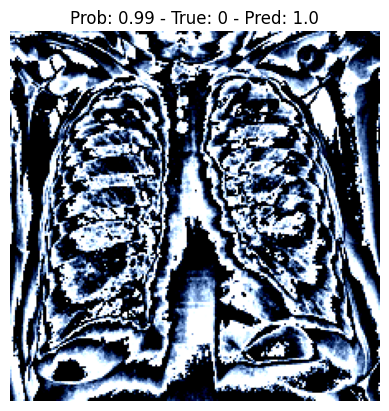

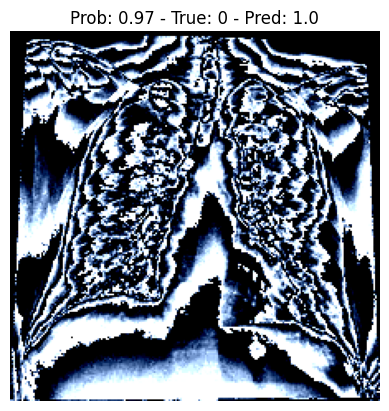

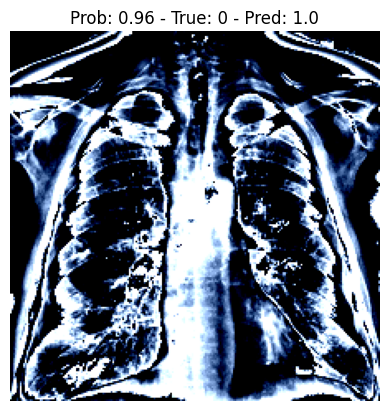

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Holdout split ---
X_train, X_val, y_train, y_val = train_test_split(
    processed_imgs, labels, test_size=0.2, stratify=labels, random_state=42)

# --- Datasets e loaders ---
# Ensure labels are integers when creating datasets
train_dataset = ImageDataset(X_train, y_train.reset_index(drop=True).astype(int), transform=train_transform)
val_dataset = ImageDataset(X_val, y_val.reset_index(drop=True).astype(int), transform=val_transform)

# --- WeightedRandomSampler (opcional, mas recomendado) ---
# Ensure labels are integers before calculating class counts
labels_np = np.array(y_train).astype(int)
class_sample_count = np.array([len(np.where(labels_np == t)[0]) for t in np.unique(labels_np)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in labels_np])
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# --- Modelo: ResNet34 ---
model = models.resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes
model = model.to(device)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# --- Treinamento ---
criterion = FocalLoss(alpha=1.0, gamma=2.0)
#criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 50
patience = 10
best_val_loss = float('inf')
best_model_weights = None
epochs_no_improve = 0

# Para plot
train_losses = []
val_losses = []
f1_scores = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for images, labels_batch in train_loader:
        images, labels_batch = images.to(device), labels_batch.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    # --- Validação ---
    model.eval()
    val_loss_total = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels_batch in val_loader:
            images, labels_batch = images.to(device), labels_batch.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels_batch)
            val_loss_total += loss.item() * images.size(0)
            all_preds.append(outputs.cpu())
            all_labels.append(labels_batch.cpu())

    val_loss = val_loss_total / len(val_loader.dataset)
    logits = torch.cat(all_preds)
    true_labels = torch.cat(all_labels)
    probs = torch.softmax(logits, dim=1)[:, 1].numpy()
    preds = (probs > 0.5).astype(np.float32)
    true = true_labels.numpy()
    f1 = f1_score(true, preds, zero_division=0)

    # Armazena para plot
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    f1_scores.append(f1)

    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, F1: {f1:.4f}")

    # Scheduler
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        best_model_weights = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"⏹️ Early stopping no epoch {epoch+1}")
            break

# --- Avaliação final ---
if best_model_weights:
    model.load_state_dict(best_model_weights)

model.eval()
logits_list = []
labels_list = []

with torch.no_grad():
    for images, labels_batch in val_loader:
        images = images.to(device)
        outputs = model(images)
        logits_list.append(outputs.cpu())
        labels_list.append(labels_batch)

logits = torch.cat(logits_list)
true_labels = torch.cat(labels_list)
probs = torch.softmax(logits, dim=1)[:, 1].numpy()
preds = (probs > 0.5).astype(np.float32)
true = true_labels.numpy()

# --- Métricas finais ---
acc = accuracy_score(true, preds)
prec = precision_score(true, preds, zero_division=0)
rec = recall_score(true, preds, zero_division=0)
f1 = f1_score(true, preds, zero_division=0)

print("\n📊 Avaliação Final (Holdout - ResNet34 + Scheduler)")
print(f"Acurácia: {acc:.4f}")
print(f"Precisão: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

# --- Gráficos de evolução ---
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss por época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(f1_scores, label='F1-score')
plt.title("F1-score por época")
plt.xlabel("Época")
plt.ylabel("F1-score")
plt.legend()
plt.tight_layout()
plt.show()

# --- Distribuição das probabilidades ---
plt.hist(probs, bins=30)
plt.title("Distribuição das probabilidades - Classe COVID+")
plt.xlabel("Probabilidade prevista")
plt.ylabel("Frequência")
plt.show()

# --- Visualização dos erros mais confiantes ---
erro_idx = np.where(preds != true)[0]
confidencias = np.abs(probs[erro_idx] - 0.5)
top_confusos = erro_idx[np.argsort(-confidencias)[:5]]

print("\n🧪 Erros mais confiantes:")
for i in top_confusos:
    plt.imshow(X_val[i])
    plt.title(f"Prob: {probs[i]:.2f} - True: {true[i]} - Pred: {preds[i]}")
    plt.axis('off')
    plt.show()

# ShuffleNET

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from torch.utils.data import Dataset
import torch
import numpy as np
from torchvision import transforms

class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        images: np.ndarray com shape (N, H, W) ou (N, H, W, 3)
        labels: lista, np.ndarray ou pd.Series
        transform: torchvision.transforms (incluindo ToTensor + Normalize)
        """
        self.images = images
        self.labels = np.array(labels)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        # Garante 3 canais (RGB)
        if image.ndim == 2:
            image = np.stack([image] * 3, axis=-1)

        image = image.astype(np.uint8)  # necessário para ToPILImage()

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return image, label

In [ ]:
# --- Transforms (ImageNet normalization) ---
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.ToPILImage(),       # de np.uint8 → PIL.Image
    transforms.ToTensor(),         # de PIL → tensor [0, 1], com shape (C, H, W)
    transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [ ]:
# --- Transforms (Com Data Augmentation) ---
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


Epoch 1 - Train Loss: 0.6816, Val Loss: 0.6586, F1: 0.7550
Epoch 2 - Train Loss: 0.6412, Val Loss: 0.8270, F1: 0.5421
Epoch 3 - Train Loss: 0.5753, Val Loss: 0.9995, F1: 0.4444
Epoch 4 - Train Loss: 0.5187, Val Loss: 0.9671, F1: 0.5000
Epoch 5 - Train Loss: 0.4892, Val Loss: 0.9313, F1: 0.7231
Epoch 6 - Train Loss: 0.4724, Val Loss: 0.8295, F1: 0.6929
Epoch 7 - Train Loss: 0.4375, Val Loss: 0.7185, F1: 0.7218
Epoch 8 - Train Loss: 0.3820, Val Loss: 0.7352, F1: 0.6825
Epoch 9 - Train Loss: 0.3057, Val Loss: 0.7832, F1: 0.6935
Epoch 10 - Train Loss: 0.3194, Val Loss: 0.8072, F1: 0.7538
Epoch 11 - Train Loss: 0.3278, Val Loss: 0.9572, F1: 0.6942
Epoch 12 - Train Loss: 0.3267, Val Loss: 0.8839, F1: 0.7107
Epoch 13 - Train Loss: 0.2878, Val Loss: 0.7552, F1: 0.7424
Epoch 14 - Train Loss: 0.2796, Val Loss: 0.7636, F1: 0.7519
Epoch 15 - Train Loss: 0.2658, Val Loss: 0.7887, F1: 0.7231
Epoch 16 - Train Loss: 0.2632, Val Loss: 0.8441, F1: 0.6891
Epoch 17 - Train Loss: 0.2831, Val Loss: 0.8559, 

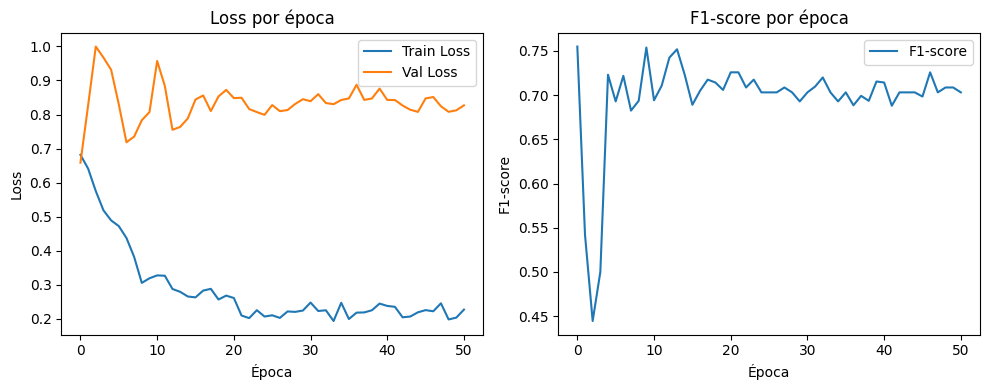

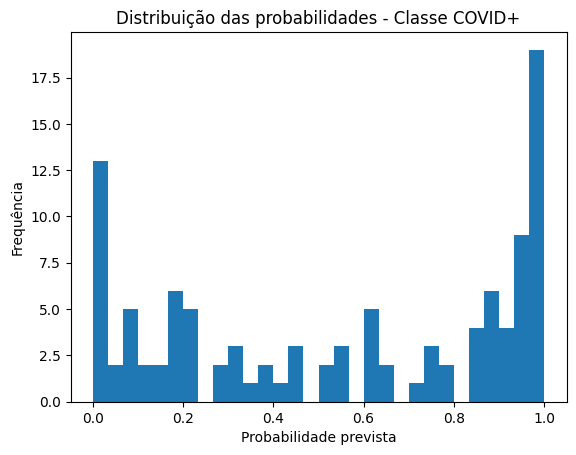


🧪 Erros mais confiantes:


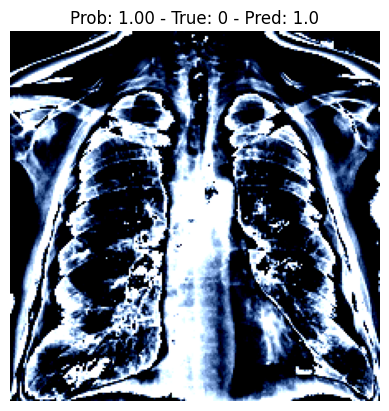

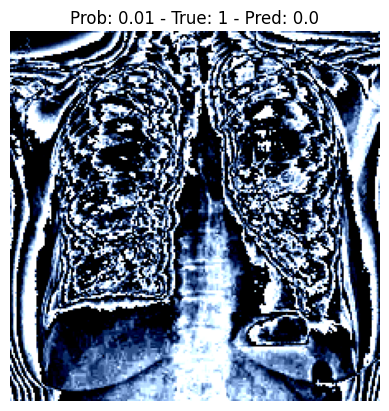

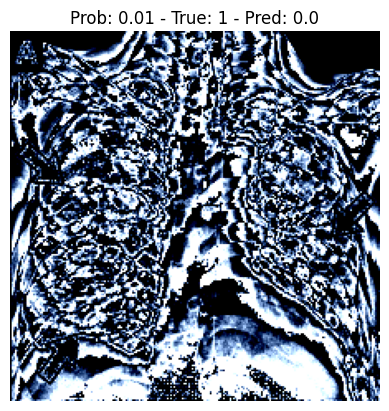

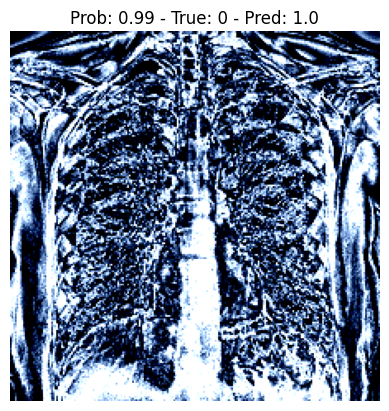

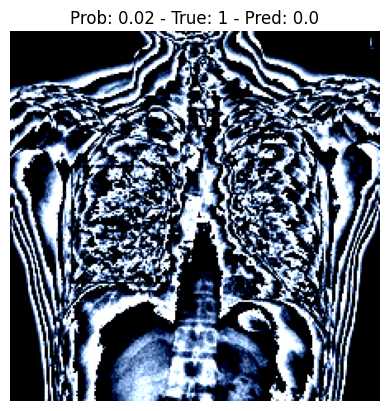

In [ ]:
# --- Dispositivo ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Holdout split ---
X_train, X_val, y_train, y_val = train_test_split(processed_imgs, labels, test_size=0.2, stratify=labels, random_state=42)

# --- Datasets e Loaders ---
train_dataset = ImageDataset(X_train, y_train.reset_index(drop=True).astype(int), transform=train_transform)
val_dataset   = ImageDataset(X_val, y_val.reset_index(drop=True).astype(int), transform=val_transform)

labels_np = np.array(y_train).astype(int)
class_counts = np.bincount(labels_np)
class_weights = 1. / class_counts
sample_weights = np.array([class_weights[t] for t in labels_np])
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# --- Modelo: ShuffleNetV2 + descongelamento parcial ---
model = models.shufflenet_v2_x1_0(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes
model = model.to(device)

# Descongela stage4, conv5 e fc
for name, param in model.named_parameters():
    if 'stage4' in name or 'conv5' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# --- Loss e otimizador ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- Scheduler ---
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# --- Treinamento ---
n_epochs = 200
patience = 50
best_val_loss = float('inf')
best_model_weights = None
epochs_no_improve = 0

train_losses, val_losses, f1_scores = [], [], []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for images, labels_batch in train_loader:
        images, labels_batch = images.to(device), labels_batch.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    # --- Validação ---
    model.eval()
    val_loss_total = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels_batch in val_loader:
            images, labels_batch = images.to(device), labels_batch.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels_batch)
            val_loss_total += loss.item() * images.size(0)
            all_preds.append(outputs.cpu())
            all_labels.append(labels_batch.cpu())

    val_loss = val_loss_total / len(val_loader.dataset)
    logits = torch.cat(all_preds)
    true_labels = torch.cat(all_labels)
    probs = torch.softmax(logits, dim=1)[:, 1].numpy()
    preds = (probs > 0.5).astype(np.float32)
    true = true_labels.numpy()
    f1 = f1_score(true, preds, zero_division=0)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    f1_scores.append(f1)

    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, F1: {f1:.4f}")
    scheduler.step(val_loss)

    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        best_model_weights = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"⏹️ Early stopping no epoch {epoch+1}")
            break

# --- Avaliação final ---
if best_model_weights:
    model.load_state_dict(best_model_weights)

model.eval()
logits_list = []
labels_list = []
with torch.no_grad():
    for images, labels_batch in val_loader:
        images = images.to(device)
        outputs = model(images)
        logits_list.append(outputs.cpu())
        labels_list.append(labels_batch)

logits = torch.cat(logits_list)
true_labels = torch.cat(labels_list)
probs = torch.softmax(logits, dim=1)[:, 1].numpy()
preds = (probs > 0.5).astype(np.float32)
true = true_labels.numpy()

acc = accuracy_score(true, preds)
prec = precision_score(true, preds, zero_division=0)
rec = recall_score(true, preds, zero_division=0)
f1 = f1_score(true, preds, zero_division=0)

print("\n📊 Avaliação Final (Holdout - ShuffleNetV2)")
print(f"Acurácia: {acc:.4f}")
print(f"Precisão: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

# --- Gráficos ---
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss por época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(f1_scores, label='F1-score')
plt.title("F1-score por época")
plt.xlabel("Época")
plt.ylabel("F1-score")
plt.legend()
plt.tight_layout()
plt.show()

plt.hist(probs, bins=30)
plt.title("Distribuição das probabilidades - Classe COVID+")
plt.xlabel("Probabilidade prevista")
plt.ylabel("Frequência")
plt.show()

# --- Visualização dos erros mais confiantes ---
erro_idx = np.where(preds != true)[0]
confidencias = np.abs(probs[erro_idx] - 0.5)
top_confusos = erro_idx[np.argsort(-confidencias)[:5]]

print("\n🧪 Erros mais confiantes:")
for i in top_confusos:
    plt.imshow(X_val[i])
    plt.title(f"Prob: {probs[i]:.2f} - True: {true[i]} - Pred: {preds[i]}")
    plt.axis('off')
    plt.show()

# EfficientNet

In [ ]:
from torchvision.models import efficientnet_b0

Epoch 1 - Train Loss: 0.6741, Val Loss: 0.7041, F1: 0.5632
Epoch 2 - Train Loss: 0.5636, Val Loss: 0.6447, F1: 0.7951
Epoch 3 - Train Loss: 0.4918, Val Loss: 0.9912, F1: 0.5989
Epoch 4 - Train Loss: 0.3957, Val Loss: 0.9464, F1: 0.6383
Epoch 5 - Train Loss: 0.3316, Val Loss: 0.9215, F1: 0.6118
Epoch 6 - Train Loss: 0.3254, Val Loss: 1.0440, F1: 0.6386
Epoch 7 - Train Loss: 0.2398, Val Loss: 0.6728, F1: 0.7426
Epoch 8 - Train Loss: 0.2198, Val Loss: 0.6392, F1: 0.7513
Epoch 9 - Train Loss: 0.1936, Val Loss: 0.7062, F1: 0.7565
Epoch 10 - Train Loss: 0.1901, Val Loss: 0.6696, F1: 0.7788
Epoch 11 - Train Loss: 0.1552, Val Loss: 0.7945, F1: 0.7451
Epoch 12 - Train Loss: 0.1631, Val Loss: 0.7523, F1: 0.6919
Epoch 13 - Train Loss: 0.1232, Val Loss: 0.7725, F1: 0.7234
Epoch 14 - Train Loss: 0.1327, Val Loss: 0.8003, F1: 0.7222
Epoch 15 - Train Loss: 0.0757, Val Loss: 0.8014, F1: 0.7151
Epoch 16 - Train Loss: 0.0764, Val Loss: 0.8391, F1: 0.7293
Epoch 17 - Train Loss: 0.0770, Val Loss: 0.7738, 

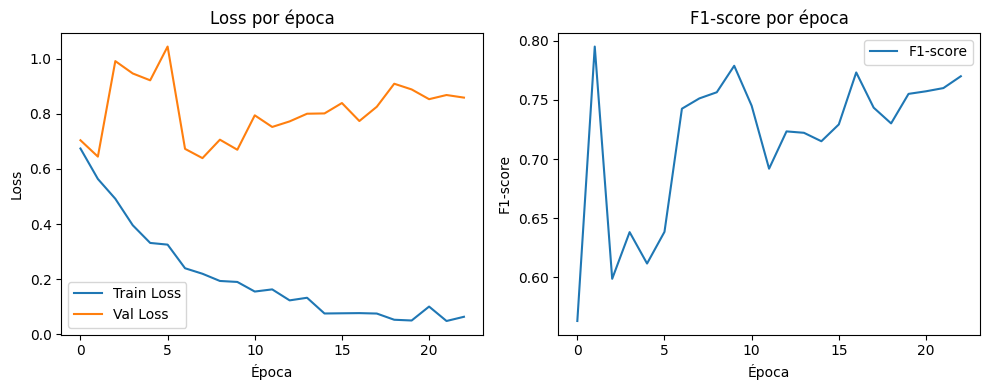

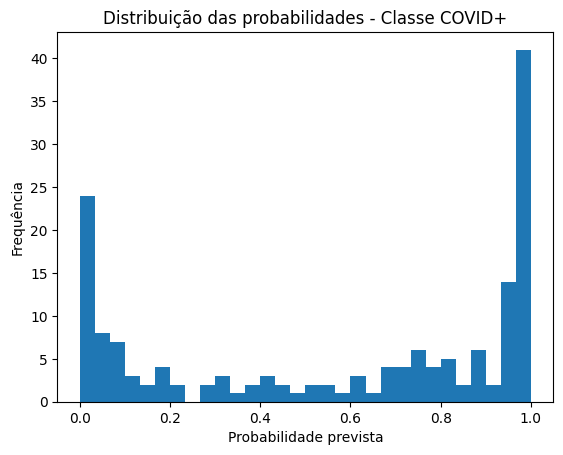

In [ ]:
# --- Dispositivo ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Holdout split ---
X_train, X_val, y_train, y_val = train_test_split(processed_imgs, labels, test_size=0.3, stratify=labels, random_state=42)

# --- Datasets e Loaders ---
train_dataset = ImageDataset(X_train, y_train.reset_index(drop=True).astype(int), transform=train_transform)
val_dataset   = ImageDataset(X_val, y_val.reset_index(drop=True).astype(int), transform=val_transform)

labels_np = np.array(y_train).astype(int)
class_counts = np.bincount(labels_np)
class_weights = 1. / class_counts
sample_weights = np.array([class_weights[t] for t in labels_np])
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# --- Modelo: ShuffleNetV2 + descongelamento parcial ---
model = efficientnet_b0(pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),  # aumenta o dropout da cabeça
    nn.Linear(model.classifier[1].in_features, 2)
)
model = model.to(device)
for name, param in model.named_parameters():
    if "features.5" in name or "features.6" in name or "features.7" in name or "classifier" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# --- Loss e otimizador ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# --- Scheduler ---
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# --- Treinamento ---
n_epochs = 200
patience = 15
best_val_loss = float('inf')
best_model_weights = None
epochs_no_improve = 0

train_losses, val_losses, f1_scores = [], [], []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for images, labels_batch in train_loader:
        images, labels_batch = images.to(device), labels_batch.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    # --- Validação ---
    model.eval()
    val_loss_total = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels_batch in val_loader:
            images, labels_batch = images.to(device), labels_batch.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels_batch)
            val_loss_total += loss.item() * images.size(0)
            all_preds.append(outputs.cpu())
            all_labels.append(labels_batch.cpu())

    val_loss = val_loss_total / len(val_loader.dataset)
    logits = torch.cat(all_preds)
    true_labels = torch.cat(all_labels)
    probs = torch.softmax(logits, dim=1)[:, 1].numpy()
    preds = (probs > 0.5).astype(np.float32)
    true = true_labels.numpy()
    f1 = f1_score(true, preds, zero_division=0)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    f1_scores.append(f1)

    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, F1: {f1:.4f}")
    scheduler.step(val_loss)

    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        best_model_weights = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"⏹️ Early stopping no epoch {epoch+1}")
            break

# --- Avaliação final ---
if best_model_weights:
    model.load_state_dict(best_model_weights)

model.eval()
logits_list = []
labels_list = []
with torch.no_grad():
    for images, labels_batch in val_loader:
        images = images.to(device)
        outputs = model(images)
        logits_list.append(outputs.cpu())
        labels_list.append(labels_batch)

logits = torch.cat(logits_list)
true_labels = torch.cat(labels_list)
probs = torch.softmax(logits, dim=1)[:, 1].numpy()
preds = (probs > 0.5).astype(np.float32)
true = true_labels.numpy()

acc = accuracy_score(true, preds)
prec = precision_score(true, preds, zero_division=0)
rec = recall_score(true, preds, zero_division=0)
f1 = f1_score(true, preds, zero_division=0)

print("\n📊 Avaliação Final (Holdout - EfficientNet)")
print(f"Acurácia: {acc:.4f}")
print(f"Precisão: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

# --- Gráficos ---
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss por época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(f1_scores, label='F1-score')
plt.title("F1-score por época")
plt.xlabel("Época")
plt.ylabel("F1-score")
plt.legend()
plt.tight_layout()
plt.show()

plt.hist(probs, bins=30)
plt.title("Distribuição das probabilidades - Classe COVID+")
plt.xlabel("Probabilidade prevista")
plt.ylabel("Frequência")
plt.show()

# --- Visualização dos erros mais confiantes ---
erro_idx = np.where(preds != true)[0]
confidencias = np.abs(probs[erro_idx] - 0.5)
top_confusos = erro_idx[np.argsort(-confidencias)[:5]]

# Rascunhos

###XCOVNet

In [ ]:
img = processed_imgs[0]  # shape (224, 224, 3)
print("Min:", img.min())
print("Max:", img.max())
print("Mean por canal:", img.mean(axis=(0, 1)))

Min: -2.1179039301310043
Max: 2.6399999999999997
Mean por canal: [0.11887853 0.25099635 0.47210304]


In [ ]:
from torch.utils.data import Dataset
import torch
import numpy as np

class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images  # numpy array (N, 224, 224, 3), já normalizado
        self.labels = np.array(labels)  # garantimos indexação por inteiro

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # (H, W, C) com float32 já normalizado
        image = image.transpose(2, 0, 1)  # para (C, H, W)

        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(int(self.labels[idx]), dtype=torch.long)

        return image, label


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class XCOVNet(nn.Module):

    def __init__(self):
        super().__init__()

        # Primeira Conv
        # input 224x224, output=32x224x224
        self.conv1 = nn.Conv2d(in_channels = 3,
                            out_channels = 32,
                            kernel_size = (3,3),
                            padding = 1)

        self.act1 = nn.ReLU()

        self.pool1 = nn.MaxPool2d(kernel_size = (2,2),
                                  stride = 2)
        self.drop1 = nn.Dropout(0.25)

        # Segunda Conv
        self.conv2 = nn.Conv2d(in_channels = 32,
                            out_channels = 64,
                            kernel_size = (3,3),
                            padding = 1)

        self.act2 = nn.ReLU()

        self.pool2 = nn.MaxPool2d(kernel_size = (2,2),
                                  stride = 2)

        self.drop2 = nn.Dropout(0.25)

        # Terceira Conv
        self.conv3 = nn.Conv2d(in_channels = 64,
                            out_channels = 128,
                            kernel_size = (3,3),
                            padding = 1)

        self.act3 = nn.ReLU()

        self.pool3 = nn.MaxPool2d(kernel_size = (2,2),
                                  stride = 2)

        self.drop3 = nn.Dropout(0.25)

        # Lineares
        self.flatten_size = 128 * 28 * 28  # após 3 poolings em imagem 224x224
        self.fc1 = nn.Linear(self.flatten_size, 30)
        self.act_fc1 = nn.ReLU()
        self.output = nn.Linear(30, 2)  # duas classes


    def forward(self, x):
        # primeira camada
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.drop1(x)

        # segunda camada
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.drop2(x)

        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)
        x = self.drop3(x)

        # flatten, projeção e classificação

        x = x.view(-1, self.flatten_size)

        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.output(x)

        return x

# Inicializar modelo
num_classes = 2  # número de labels



In [ ]:
from sklearn.metrics import confusion_matrix

Epoch 1 - Train Loss: 0.7655, Val Loss: 0.6932
Epoch 2 - Train Loss: 0.6940, Val Loss: 0.6931
Epoch 3 - Train Loss: 0.6939, Val Loss: 0.6931
Epoch 4 - Train Loss: 0.6931, Val Loss: 0.6931
Epoch 5 - Train Loss: 0.6931, Val Loss: 0.6931
Epoch 6 - Train Loss: 0.6931, Val Loss: 0.6931
⏹️ Early stopping triggered at epoch 6


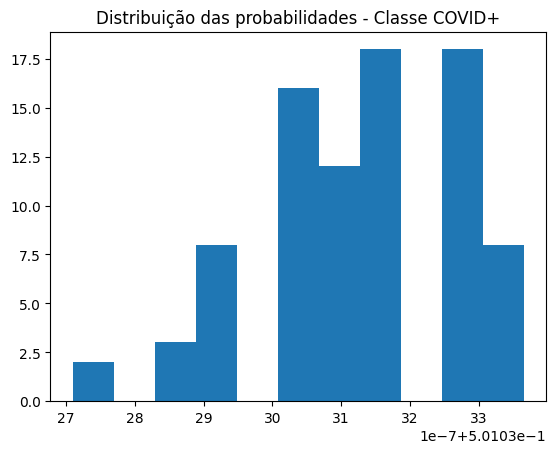


📊 Avaliação Final (Holdout)
Acurácia: 0.6355
Precisão: 0.6355
Recall: 1.0000
F1-score: 0.7771
[[ 0 39]
 [ 0 68]]


In [ ]:
# --- Parâmetros ---
test_size = 0.2
batch_size = 32
n_epochs = 50
patience = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Split Holdout ---
X_train, X_val, y_train, y_val = train_test_split(processed_imgs, labels, test_size=test_size, stratify=labels, random_state=42)

# --- Datasets e Loaders ---
train_dataset = ImageDataset(X_train, y_train.reset_index(drop=True))
val_dataset = ImageDataset(X_val, y_val.reset_index(drop=True))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# --- Pesos de classe ---
#class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor([1.76, 1.0]).to(device)  # classe 0, classe 1
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# --- Modelo, critério, otimizador ---
model = XCOVNet().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- Early Stopping ---
best_val_loss = float('inf')
best_model_weights = None
epochs_no_improve = 0

# --- Loop de treinamento ---
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for images, labels_batch in train_loader:
        images, labels_batch = images.to(device), labels_batch.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    # --- Validação ---
    model.eval()
    val_loss_total = 0.0
    preds, truths = [], []
    with torch.no_grad():
        for images, labels_batch in val_loader:
            images, labels_batch = images.to(device), labels_batch.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels_batch)
            val_loss_total += loss.item() * images.size(0)
            preds.append(outputs.cpu())
            truths.append(labels_batch.cpu())

    val_loss = val_loss_total / len(val_loader.dataset)
    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # --- Early stopping check ---
    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        best_model_weights = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"⏹️ Early stopping triggered at epoch {epoch+1}")
            break

# --- Avaliação final com os melhores pesos ---
if best_model_weights:
    model.load_state_dict(best_model_weights)

model.eval()
with torch.no_grad():
    all_outputs, all_labels = [], []
    for images, labels_batch in val_loader:
        images = images.to(device)
        outputs = model(images)
        all_outputs.append(outputs.cpu())
        all_labels.append(labels_batch)

logits = torch.cat(all_outputs)
true_labels = torch.cat(all_labels)
probs = torch.softmax(logits, dim=1)[:, 1].numpy()
preds = (probs > 0.5).astype(np.float32)
true = true_labels.numpy()

plt.hist(probs, bins=30)
plt.title("Distribuição das probabilidades - Classe COVID+")
plt.show()

# --- Métricas finais ---
acc = accuracy_score(true, preds)
prec = precision_score(true, preds, zero_division=0)
rec = recall_score(true, preds, zero_division=0)
f1 = f1_score(true, preds, zero_division=0)

print("\n📊 Avaliação Final (Holdout)")
print(f"Acurácia: {acc:.4f}")
print(f"Precisão: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print(confusion_matrix(true, preds))

### Cross Validation

In [ ]:
n_splits = 5
batch_size = 16
n_epochs_per_fold = 100
patience = 10  # número de épocas sem melhoria antes de parar
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Resultados
all_fold_covid_accuracy = []
all_fold_covid_precision = []
all_fold_covid_recall = []
all_fold_covid_f1 = []

# Validação cruzada
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(skf.split(processed_imgs, labels)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")

    X_train_fold, X_val_fold = processed_imgs[train_index], processed_imgs[val_index]
    y_train_fold, y_val_fold = labels.iloc[train_index].reset_index(drop=True), labels.iloc[val_index].reset_index(drop=True)

    train_dataset = ImageDataset(X_train_fold, y_train_fold)
    val_dataset = ImageDataset(X_val_fold, y_val_fold)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    model = XCOVNet().to(device)

    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_weights = None

    for epoch in range(n_epochs_per_fold):
        # --- Treinamento ---
        model.train()
        running_loss = 0.0
        for images, labels_batch in train_loader:
            images, labels_batch = images.to(device), labels_batch.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss_train = running_loss / len(train_loader.dataset)

        # --- Validação ---
        model.eval()
        val_running_loss = 0.0
        predictions_fold = []
        true_labels_fold = []
        with torch.no_grad():
            for images, labels_batch in val_loader:
                images, labels_batch = images.to(device), labels_batch.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels_batch)
                val_running_loss += loss.item() * images.size(0)
                predictions_fold.append(outputs.cpu())
                true_labels_fold.append(labels_batch.cpu())

        predictions_fold = torch.cat(predictions_fold)
        true_labels_fold = torch.cat(true_labels_fold)
        val_epoch_loss = val_running_loss / len(val_loader.dataset)

        print(f"  Fold {fold+1}, Epoch {epoch+1} - Treinamento Loss: {epoch_loss_train:.4f}, Validação Loss: {val_epoch_loss:.4f}")

        # --- Early stopping ---
        if val_epoch_loss < best_val_loss - 1e-4:
            best_val_loss = val_epoch_loss
            best_model_weights = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"  ⏹️ Early stopping no epoch {epoch+1}")
                break

    # Carrega os melhores pesos
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    # --- Métricas finais do fold ---
    model.eval()
    with torch.no_grad():
        outputs = []
        labels_all = []
        for images, labels_batch in val_loader:
            images = images.to(device)
            out = model(images)
            outputs.append(out.cpu())
            labels_all.append(labels_batch)

    predictions_fold = torch.cat(outputs)
    true_labels_fold = torch.cat(labels_all)
    prob_fold = torch.softmax(predictions_fold, dim=1)[:, 1].numpy()
    covid_true_fold = true_labels_fold.numpy()
    covid_pred_fold = (prob_fold > 0.5).astype(np.float32)

    covid_accuracy_fold = accuracy_score(covid_true_fold, covid_pred_fold)
    covid_precision_fold = precision_score(covid_true_fold, covid_pred_fold, zero_division=0)
    covid_recall_fold = recall_score(covid_true_fold, covid_pred_fold, zero_division=0)
    covid_f1_fold = f1_score(covid_true_fold, covid_pred_fold, zero_division=0)

    print(f"  Fold {fold+1} COVID-19 - Acurácia: {covid_accuracy_fold:.4f}, Precisão: {covid_precision_fold:.4f}, Recall: {covid_recall_fold:.4f}, F1: {covid_f1_fold:.4f}")

    all_fold_covid_accuracy.append(covid_accuracy_fold)
    all_fold_covid_precision.append(covid_precision_fold)
    all_fold_covid_recall.append(covid_recall_fold)
    all_fold_covid_f1.append(covid_f1_fold)

# --- Resultados Finais ---
print("\n--- Resultados Finais da Validação Cruzada para COVID-19 ---")
print(f"Acurácia Média: {np.mean(all_fold_covid_accuracy):.4f} +/- {np.std(all_fold_covid_accuracy):.4f}")
print(f"Precisão Média: {np.mean(all_fold_covid_precision):.4f} +/- {np.std(all_fold_covid_precision):.4f}")
print(f"Recall Médio: {np.mean(all_fold_covid_recall):.4f} +/- {np.std(all_fold_covid_recall):.4f}")
print(f"F1-score Médio: {np.mean(all_fold_covid_f1):.4f} +/- {np.std(all_fold_covid_f1):.4f}")


--- Fold 1/5 ---
  Fold 1, Epoch 1 - Treinamento Loss: 0.7422, Validação Loss: 0.6526
  Fold 1, Epoch 2 - Treinamento Loss: 0.6569, Validação Loss: 0.6521
  Fold 1, Epoch 3 - Treinamento Loss: 0.6544, Validação Loss: 0.6662
  Fold 1, Epoch 4 - Treinamento Loss: 0.6619, Validação Loss: 0.6509
  Fold 1, Epoch 5 - Treinamento Loss: 0.6607, Validação Loss: 0.6551
  Fold 1, Epoch 6 - Treinamento Loss: 0.6599, Validação Loss: 0.6530
  Fold 1, Epoch 7 - Treinamento Loss: 0.6577, Validação Loss: 0.6530
  Fold 1, Epoch 8 - Treinamento Loss: 0.6557, Validação Loss: 0.6626
  Fold 1, Epoch 9 - Treinamento Loss: 0.6607, Validação Loss: 0.6561
  Fold 1, Epoch 10 - Treinamento Loss: 0.6568, Validação Loss: 0.6518
  Fold 1, Epoch 11 - Treinamento Loss: 0.6561, Validação Loss: 0.6495
  Fold 1, Epoch 12 - Treinamento Loss: 0.6632, Validação Loss: 0.6472
  Fold 1, Epoch 13 - Treinamento Loss: 0.6539, Validação Loss: 0.6337
  Fold 1, Epoch 14 - Treinamento Loss: 0.6304, Validação Loss: 0.7278
  Fold 1, E